In [6]:
import numpy as np
import GPy
GPy.plotting.change_plotting_library('matplotlib')

import matplotlib.pyplot as plt
from scipy.optimize import minimize


def update_posterior(m, x_new):
    y = sample(x_new)
    X = np.concatenate([m.X, np.array([x_new])])
    Y = np.concatenate([m.Y, np.array([y])])
    m.set_XY(X, Y)
    m.optimize()
    
def ucb(x, m):
    kappa = 2
    mean, std = m.predict(np.array([x]))
    return (mean + kappa * std)[0]

def rand_samples(n_samples, bounds, kernel):
    dim = kernel.input_dim
    return np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_samples, dim))

def max_acq(ac, m, bounds, n_starts=100):
    min_y = 1 # TODO:
    min_x = None
    
    min_obj = lambda X: -ac(X, m)

    # TODO: parallelize
    # Find the best optimum by starting from n_restart different random points.
    for x0 in rand_samples(n_starts, bounds, m.kern):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_y:
            min_y = res.fun[0]
            min_x = res.x           
            
    return min_x

def bo(f, kernel, bounds, plot=True, n_iter=10):
    x = rand_samples(2, bounds, kernel)
    m = GPy.models.GPRegression(x, f(x), kernel)

    if plot:
        # required to plot aquisition func
        boundedX = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

    for i in range(0, n_iter):
        xnew = max_acq(ucb, m, bounds=bounds)

        if plot:
            fig = m.plot()
            fig.set_title(f'Iteration {i}')
            GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

            plt.figure()
            acY = np.fromiter((ucb(x,m) for x in boundedX), np.float)
            plt.plot(boundedX, acY, 'r-', lw=1, label='Acquisition function')
            plt.axvline(x=xnew, ls='--', c='k', lw=1, label='Next sampling location')
            plt.show()
            
        update_posterior(m, xnew)

    if plot:
        fig = m.plot()
        fig.set_title(f'Iteration {i+1}')
        GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

In [9]:
boundedX.shape

(200, 1)

In [22]:
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
Y = noisy_f(X)
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1.)
GPy.models.GPRegression(X,Y,kernel, kernel)


AssertionError: 

In [18]:
def noisy_f(x):
    return np.sin(x) + np.random.randn(*x.shape) * 0.05

input_bounds = np.array([[0,1]])
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01)
Y = noisy_f(X)
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1.)
np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1,1).shape

(200, 1)

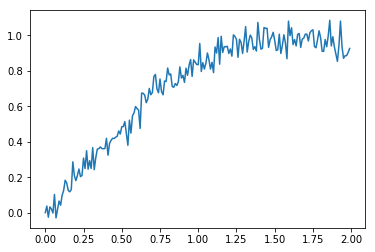

 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


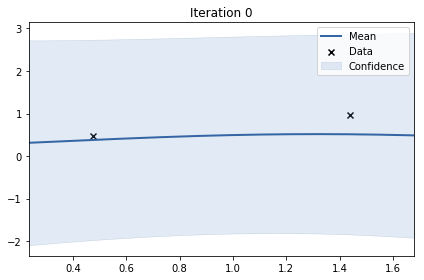

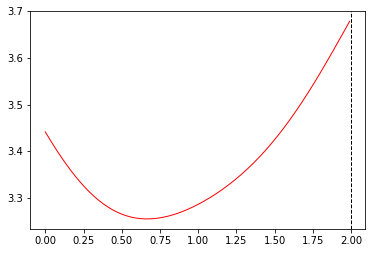

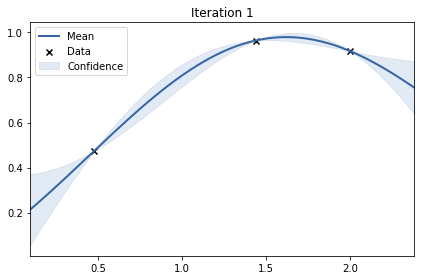

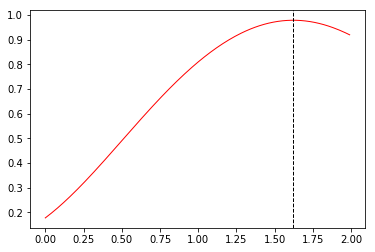

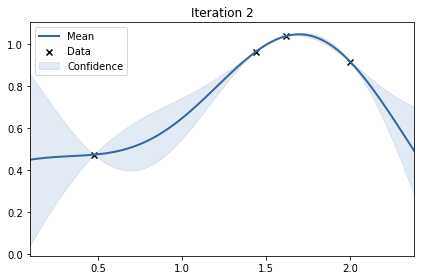

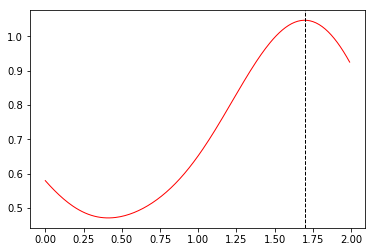

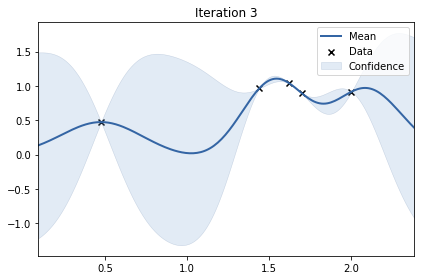

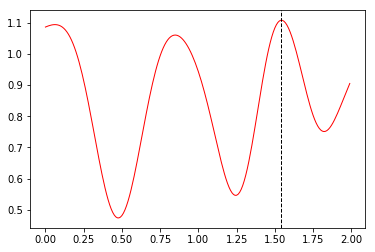

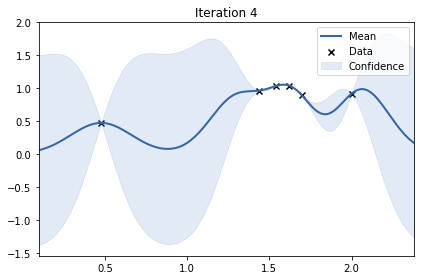

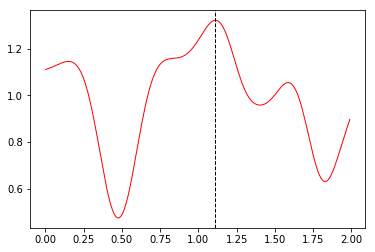

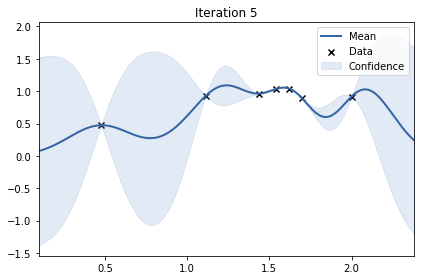

In [7]:
def sample(x):
    return np.sin(x) + np.random.randn(*x.shape) * 0.05
    # return np.sinc(x) + np.random.randn(*x.shape) * 0.05

bounds=np.array([[0,2]])
boundedX = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
plt.plot(boundedX, sample(boundedX))
    
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1.)

bo(sample, kernel, bounds=bounds, plot=True, n_iter=5)

Print articles
- Robo, BOHAMIANN, NP

Outline:
- efficient BO approximation
- Simple GP implementation
- Spearmint
- Random Forest
- DNGO is only in terms of hyperparamters.
- RoBO and BOHAMIANN has more general phrasing (sinc, sinOne).
- NP..

Concrete:
- Done some digging: What DNGO trains on? BOHAMIANN couldn't say.
- BNN doesn't require pretraining?


TODO:
- Make GP-UCB
- Summaries NP
- BNN vs DNGO
- Benchmarks
- Concrete proposal..

Proposal
--------

- BO is good for black-box functions.
- Several methods have been proposed for BO:
    - DNGO for hyperparameters:
    - BNN
    (- Ensemble: http://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf)

Notes
-----

- implement GP-UCB (how to bayesian update GP?)
- play around with bayesian linear regressor
- ensemble

Decisions:
- Pick benchmark function (1d)?
- Pick kernel for GP.
- Use benchmark function as ground truth.

Questions
---------

Neural Processes: https://arxiv.org/pdf/1807.01622.pdf
Conditional NP: https://arxiv.org/pdf/1807.01613.pdf

Benchmark
- Eggensperger et al. (Towards an
empirical foundation for assessing Bayesian optimization of hyperparameters)
- Thompson sampling
- Sine wave from BNN article
- Rosenbrock
- Branin
- Hartman3

- how many point to begin with? (two?)
- Optimisation of acquisition function? e.g. DIRECT?
- Bottleneck: inversion of matrix. Correct?

low level:
- Hyperparameter optimisation when space is continious? Rounding?

High level:
- Comparing using KL for multivariate dist?
- Run only on examples where GP method is feasable.
- We have to sample very few times (if we want to mimic BO).
- Look at parallisation BO yet?
- What functions should i train DNGO on???
- Using BNN (DNGO competitor): 
    Main article:  https://papers.nips.cc/paper/6117-bayesian-optimization-with-robust-bayesian-neural-networks.pdf
    Supplementary: https://ml.informatik.uni-freiburg.de/papers/16-NIPS-BOHamiANN-supplementary.pdf
    ROBO: https://ml.informatik.uni-freiburg.de/papers/17-BayesOpt-RoBO.pdf

    new data point: 
        - 2000 burn in. 
        - then collect ever 50 points in MCMC (total of 50)
        - approximate acquisition using points
        - Use ADAM to minimize
    
    More robust for RL and multi-task
    
    (DNGO hyperparameters where trained over unknown dataset)
     
- When searching for hyperparameters they train on smaller set it seems.. (not completely blackbox)

NN with bayesian regressor:
- Train with linear (MAP)
- Replace with Bayesian linear regressor (applied post-hoc)
- Optimize with GP spearmint

- How do they train?
- How do they update the dist? (done through updating the bayesian layer)
